# 허깅페이스 트랜스포머즈 활용한 자연어처리




---



##  🎣 낚시성기사분류기 만들기
> 기사의 제목과 본문을 입력으로 줬을때, `제목과 본문사이 관계가 아래 6가지에 포함된다면 낚시성기사로 판단 `

<center>

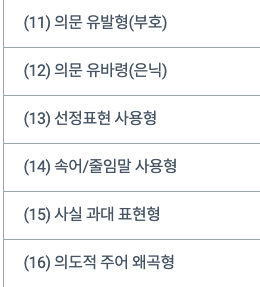

</center>

#### 실습 목차

1. Dataset & Tokenizing
  * 1-1. news_dataset class 정의
  * 1-2. load_Data, construct_tokenized_dataset 함수 정의
  * 1-3. prepare_dataset 함수 정의
2. Model & Trainer
  * 2-1. compute_metrics 함수 정의
  * 2-2. load_tokenizer_and_model_for_train 함수 정의
  * 2-3. load_trainer_for_train 함수 정의
  * 2-4. train 함수 정의
  * 2-5. arguments 지정 및 학습 진행
3. Inference & Evaluation
  * 3-1. load_model_for_inference 함수 정의
  * 3-2. inference 함수 정의
  * 3-3. infer_and_eval 함수 정의

### ⚙️ 데이터 및 환경설정
- 학습(train) 데이터와 평가(test) 데이터를 불러옵니다.
- 베이스라인에 필요한 라이브러리들을 설치합니다.
- 런타임 유형을 GPU로 설정합니다.

1.데이터 다운로드

- 아래코드 실행후 좌측 "파일" Tab 내 train.csv , test.csv 확인합니다.

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1gucFY-P9a1TzdV8Xb-OwVD4TpPy4iyJX' -O train.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1J05RaqfknDzTObofL7OyiSmT0B8rX0gZ' -O test.csv

--2025-09-13 12:14:48--  https://docs.google.com/uc?export=download&id=1gucFY-P9a1TzdV8Xb-OwVD4TpPy4iyJX
Resolving docs.google.com (docs.google.com)... 74.125.137.102, 74.125.137.101, 74.125.137.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1gucFY-P9a1TzdV8Xb-OwVD4TpPy4iyJX&export=download [following]
--2025-09-13 12:14:48--  https://drive.usercontent.google.com/download?id=1gucFY-P9a1TzdV8Xb-OwVD4TpPy4iyJX&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41620993 (40M) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]  39.69M  80.1MB/s    in 0.5

[참고용]
- [원본 데이터 링크](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=71338)
- [데이터셋 분리 코드](https://colab.research.google.com/drive/1PEwivSUeQhgR8xjWQE6Xl0Hzh_9uf3L5?usp=sharing)
- [데이터셋 저장 드라이브](https://drive.google.com/drive/folders/1r7Cn1Di9s-QlPTmieCunTP_CQjKXcnxE?usp=sharing)

2.환경설정



```
pytorch_lightning
torch
pandas
numpy
transformers
sklearn
```
- 코랩에서는 pytorch_lightning과 transformers 만 아래와 같이 설치해주면 됩니다.


In [2]:
!pip -q install pytorch_lightning
!pip -q install transformers
!pip -q install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.4 MB/s eta 0:00:00


- "런타임" > "런타임유형변경" > "Python3, T4 GPU" 선택해준 후, "런타임재실행"해줍니다.

In [3]:
import torch
torch.cuda.is_available() # GPU 할당여부 확인. GPU가 정상적으로 할당되면 True가 출력.

True

### 1️⃣ Dataset & Tokenizing
- torch.utils.data.Dataset class 를 상속받아 news_dataset class를 정의해줍니다.
- 데이터를 불러오는 load_data 와 tokenizing을 진행하는 <br> construct_tokenized_dataset 를 정의해줍니다.
-  위에서 정의된 함수들을 활용하여, 데이터셋을 불러와 tokenizing 한후에, <br> torch dataset class로 변환해줍니다.
- 이후 train data /validation data 는 7.5 : 2.5로 나눠줍니다.

####1-1. <b> news_dataset class </b> 정의

In [4]:
import os
import pandas as pd
import torch

class news_dataset(torch.utils.data.Dataset):
    """dataframe을 torch dataset class로 변환"""
    def __init__(self, news_dataset, labels):
        self.dataset = news_dataset
        self.labels = labels

    def __getitem__(self,idx):
        item = {
            key: val[idx].clone().detach() for key, val in self.dataset.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

####1-2. <b>load_data , construct_tokenized_dataset</b> 함수 정의
- "데이터를 불러오고" "토크나이징 해주는" 함수들

In [5]:
def load_data(dataset_dir):
    """csv file을 dataframe으로 load"""
    dataset = pd.read_csv(dataset_dir)[:500]
    print("dataframe 의 형태")
    print(dataset.head())
    return dataset

def construct_tokenized_dataset(dataset,tokenizer, max_length):
    """[뉴스제목 + [SEP] + 뉴스본문]형태로 토크나이징"""
    concat_entity = []
    for title, body in zip(dataset["newsTitle"],dataset["newsContent"]):
        total = str(title) + "[SEP]" + str(body)
        concat_entity.append(total)
    print("tokenizer 에 들어가는 데이터 형태")
    print(concat_entity[:5])
    tokenized_senetences = tokenizer(
        concat_entity,
        return_tensors = "pt",
        padding = True,
        truncation = True,
        max_length = max_length,
        add_special_tokens = True,
        # return_token_type_ids=False, # BERT 이후 모델(RoBERTa 등) 사용할때 False
    )
    print("tokenizing 된 데이터 형태")
    print(tokenized_senetences[:5])
    return tokenized_senetences

####1-3. prepare_dataset 함수 정의
- 앞서 정의한 함수들 기반으로 데이터셋 준비하는 함수

🌟 전처리과정 🌟<blockquote>
1. train.csv / test.csv 파일을 pd.dataframe 로 다운로드 해준다. <br>
2. train/validation set을 나눠준다. (7.5:2.5) <br>
3. label 값을 따로 저장해준다. <br>
4. 제목과 본문 데이터만 정제한후에 tokenizing 해준다. <br>
5. tokenizing 된 데이터를 news_dataset class로 반환해준다. <br>

In [6]:
def prepare_dataset(dataset_dir, tokenizer,max_len):
    """학습(train)과 평가(test)를 위한 데이터셋을 준비"""
    # load_data
    train_dataset = load_data(os.path.join(dataset_dir, "train.csv"))
    test_dataset = load_data(os.path.join(dataset_dir, "test.csv"))

    # split train / validation = 7.5 : 2.5
    train_dataset, val_dataset = train_test_split(train_dataset,test_size=0.25,random_state=42,stratify=train_dataset['label'])

    # split label
    train_label = train_dataset['label'].values
    val_label = val_dataset['label'].values
    test_label = test_dataset['label'].values

    # tokenizing dataset
    tokenized_train = construct_tokenized_dataset(train_dataset, tokenizer, max_len)
    tokenized_val = construct_tokenized_dataset(val_dataset, tokenizer, max_len)
    tokenized_test = construct_tokenized_dataset(test_dataset, tokenizer, max_len)
    print("--- tokenizing Done ---")

    # make dataset for pytorch.
    news_train_dataset = news_dataset(tokenized_train, train_label)
    news_val_dataset = news_dataset(tokenized_val, val_label)
    news_test_dataset = news_dataset(tokenized_test, test_label)
    print("--- dataset class Done ---")

    return news_train_dataset , news_val_dataset, news_test_dataset , test_dataset

### 2️⃣ Model & Trainer
- huggingface 에서 사전학습된(pre-trained) 모델을 불러옵니다.
- huggingface 의 Trainer 모듈을 정의하고 학습에 사용될 Arguments 들을 지정해줍니다.

In [7]:
import os
import random
import numpy as np
import pytorch_lightning as pl
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
)
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup

####2-1. compute_metrics 함수 정의
- 학습 중 validation 할때 사용될 평가지표 정의하는 함수
- 해당 실습에서는 Accuracy와 F1 Score를 Metric으로 사용

In [8]:
def compute_metrics(pred):
    """validation을 위한 metrics function"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)

    # calculate f1 score using sklearn's function
    f1 = f1_score(labels, preds, average='micro')

    return {
        "accuracy": acc,
        "f1": f1,
    }

####2-2.load_tokenizer_and_model_for_train 함수 정의
- 학습에 사용될 토크나이저와 모델을 불러오는 함수

In [9]:
from transformers import AutoModelForSequenceClassification
test_model= AutoModelForSequenceClassification.from_pretrained('klue/roberta-large')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(test_model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [10]:
def load_tokenizer_and_model_for_train():
    """학습(train)을 위한 사전학습(pretrained) 토크나이저와 모델을 huggingface에서 load"""
    # load model and tokenizer
    MODEL_NAME = args.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # setting model hyperparameter
    model_config = AutoConfig.from_pretrained(MODEL_NAME)
    model_config.num_labels = 2
    print(model_config)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, config=model_config
    )
    print("--- Modeling Done ---")
    return tokenizer , model

####2-3.load_trainer_for_train 함수 정의
- 학습에 사용될 Trainer 모듈을 정의하고 Arguments들을 지정해준다.

In [11]:
def load_trainer_for_train(model,news_train_dataset,news_val_dataset):
    """학습(train)을 위한 huggingface trainer 설정"""
    training_args = TrainingArguments(
        output_dir=args.save_path + "results",  # output directory
        save_total_limit=args.save_limit,  # number of total save model.
        save_steps=args.save_step,  # model saving step.
        num_train_epochs=args.epochs,  # total number of training epochs
        learning_rate=args.lr,  # learning_rate
        per_device_train_batch_size=args.batch_size,  # batch size per device during training
        per_device_eval_batch_size=2,  # batch size for evaluation
        warmup_steps=args.warmup_steps,  # number of warmup steps for learning rate scheduler
        weight_decay=args.weight_decay,  # strength of weight decay
        logging_dir=args.save_path + "logs",  # directory for storing logs
        logging_steps=args.logging_step,  # log saving step.
        eval_strategy="steps",  # evaluation strategy to adopt during training
            # `no`: No evaluation during training.
            # `steps`: Evaluate every `eval_steps`.
            # `epoch`: Evaluate every end of epoch.
        eval_steps=args.eval_step,  # evaluation step.
        load_best_model_at_end=True,
    )

    ## Add callback & optimizer & scheduler
    MyCallback = EarlyStoppingCallback(
        early_stopping_patience=3, early_stopping_threshold=0.001
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=args.lr,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=args.weight_decay,
        amsgrad=False,
    )
    print("--- Set training arguments Done ---")

    trainer = Trainer(
        model=model,  # the instantiated 🤗 Transformers model to be trained
        args=training_args,  # training arguments, defined above
        train_dataset=news_train_dataset,  # training dataset
        eval_dataset=news_val_dataset,  # evaluation dataset
        compute_metrics=compute_metrics,  # define metrics function
        callbacks=[MyCallback],
        optimizers=(
            optimizer,
            get_cosine_with_hard_restarts_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=args.warmup_steps,
                    num_training_steps=len(news_train_dataset) * args.epochs,
            ),
        ),
    )
    print("--- Set Trainer Done ---")

    return trainer


####2-4.train 함수 정의
- 실험세팅 후 앞서 정의한 함수들 활용하여 학습을 진행하는 함수

🌟 학습동작과정 🌟
<blockquote>
1. 실험에 영향을 주는 모든 seed를 고정해준다. <br>
2. 사용할 gpu를 device에 할당해준다. <br>
3. tokenizer와 model을 불러온후, model을 device에 할당해준다. <br>
4. 학습에 사용될 news_dataset 을 불러온다.<br>
5. 학습에 사용될 Trainer 를 불러온다.<br>
6. 학습을 진행한후에 best_model을 저장해준다. <br>

In [12]:
def train():
    """모델을 학습(train)하고 best model을 저장"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # set model and tokenizer
    tokenizer , model = load_tokenizer_and_model_for_train()
    model.to(device)

    # set data
    news_train_dataset, news_val_dataset, news_test_dataset, test_dataset = prepare_dataset(args.dataset_dir,tokenizer,args.max_len)

    # set trainer
    trainer = load_trainer_for_train(model,news_train_dataset,news_val_dataset)

    # train model
    print("--- Start train ---")
    trainer.train()
    print("--- Finish train ---")
    model.save_pretrained("./best_model")


####2-5.arguments 지정 및 학습 진행
- RoBERTa 모델 간략 설명

<blockquote>
1. BERT 모델의 변형으로, 학습 데이터의 양을 크게 늘리고 학습률(learning rate)을 조정하며, <br>문장의 길이를 다양화하여 성능을 향상시켰다. <br>
2. BERT의 사전학습 방법 중 하나인 NSP(Next Sentence Prediction)을 제거하였다.

In [13]:
class args ():
  """학습(train)과 추론(infer)에 사용되는 arguments 관리하는 class"""
  dataset_dir = "./"
  model_type = "roberta" # 다른 모델 사용 가능 e.g) "bert" , "electra" ···
  model_name = "klue/roberta-large" # 다른 모델 사용 가능 e.g) "klue/bert-base" , "monologg/koelectra-base-finetuned-nsmc" ···
  save_path = "./"
  save_step = 200
  logging_step = 200
  eval_step = 100
  save_limit = 5
  seed = 42
  epochs = 1 # 10
  batch_size = 8 # 메모리 상황에 맞게 조절 e.g) 16 or 32
  max_len = 128
  lr = 3e-5
  weight_decay = 0.01
  warmup_steps = 300
  scheduler = "linear"
  model_dir = "./best_model" #추론 시, 저장된 모델 불러오는 경로 설정



In [14]:
train()

INFO:lightning_fabric.utilities.seed:Seed set to 42


device: cuda:0


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertTokenizer",
  "transformers_version": "4.56.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32000
}

--- Modeling Done ---
dataframe 의 형태
   Unnamed: 0 newsCategory newsSubcategory                        newsTitle  \
0       12529           경제           금융/증권  김종민 대전산단협회장 “산단 발전과 인식변화 위해 노력”   
1        4815           경제              유통     힐튼 가든 인, 내달 1일 루프톱 야외 수영장 개장   
2       11556           경제  

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kkndsss0 (kkndsss0-sesac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


--- Finish train ---


### 3️⃣ Inference & Evaluation
- 학습완료된(fine-tuned) 모델을 불러와서 추론(infer)을 진행합니다.
- 추론된 예측값들과 정답값을 비교하여 평가(evaluation)합니다.

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

####3-1.load_model_for_inference 함수 정의
- 학습된(fine-tuned) 모델의 체크포인트(checkpoint)를 불러오는 함수 <br>
<b>(이때, 토크나이저는 기존과 동일하게 huggingface 에서 불러온다. )</b>


In [16]:
def load_model_for_inference():
    """추론(infer)에 필요한 모델과 토크나이저 load """
    # load tokenizer
    Tokenizer_NAME = args.model_name
    tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

    ## load my model
    model = AutoModelForSequenceClassification.from_pretrained(args.model_dir)

    return tokenizer, model

####3-2. inference 함수 정의
- 학습된(fine-tuned)모델을 통해 평가 데이터의 예측값 추론해내는 함수

🌟 추론(infer) 계산과정 🌟

<blockquote>
1. model.eval , torh.no_grad 를 통해 모델을 추론 모드로 변경 <br>
2. 모델에 입력값으로 input_ids 와 attention mask를 <b>gpu에 할당한 후</b> 입력으로 주고 결과값(outputs) 생성 <br>
3. 결과값(outputs) 중 logits 값을 cpu로 할당한 후, argmax 를 통해 예측 레이블(label) 생성 <br>
4. 생성된 레이블(label) 을 concat 하여 리스트 형태로 반환

In [17]:
def inference(model, tokenized_sent, device):
    """학습된(trained) 모델을 통해 결과를 추론하는 function"""
    dataloader = DataLoader(tokenized_sent, batch_size=args.batch_size, shuffle=False)
    model.eval()
    output_pred = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
                input_ids=data["input_ids"].to(device),
                attention_mask=data["attention_mask"].to(device),
            )
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        result = np.argmax(logits, axis=-1)

        output_pred.append(result)
    return (np.concatenate(output_pred).tolist(),)

####3-3.infer_and_eval 함수 정의
- 학습된(fine-tuned) 모델로 추론(infer)한 후 예측한 결과를 평가(evaluation)하는 함수

<blockquote>
1. 사용할 gpu를 device에 할당해준다. <br>
2. tokenizer와 model을 불러온후, model을 device에 할당해준다. <br>
3. 추론에 사용될 news_dataset 을 불러온다.<br>
4. model 과 news_dataset을 입력으로 주고 추론(infer)을 진행한다. <br>
5. test data 의 레이블(label)과 예측값(pred)을 비교하여 평가지표를 계산한다.<br>
6. 최종 예측값을 csv 형태로 저장해준다. <br>

In [18]:
def infer_and_eval():
    """학습된 모델로 추론(infer)한 후에 예측한 결과(pred)를 평가(eval)"""
    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # set model & tokenizer
    tokenizer, model = load_model_for_inference()
    model.to(device)

    # set data
    news_train_dataset, news_val_dataset, news_test_dataset, test_dataset = prepare_dataset(args.dataset_dir,tokenizer,args.max_len)

    # predict answer
    pred_answer = inference(model, news_test_dataset, device)  # model에서 class 추론
    print("--- Prediction done ---")

    # evaluate between label and prediction
    labels = test_dataset['label'].values
    pred = pred_answer[0]

    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    print(f" ----- accuracy:{acc * 100:.1f}% -----")
    print(f"----- f1_score(macro): {f1 * 100:.1f}% ------")

    # make csv file with predicted answer
    output = pd.DataFrame(
        {
            "title": test_dataset["newsTitle"],
            "cleanBody": test_dataset["newsContent"],
            "clickbaitClass": pred,
        }
    )

    # 최종적으로 완성된 예측한 라벨 csv 파일 형태로 저장.
    result_path = "./prediction/"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    output.to_csv(
        os.path.join(result_path,"result.csv"), index=False
    )
    print("--- Save result ---")
    return output

- 추론 및 평가 진행 후 결과값 10개까지 출력

In [19]:
output_df = infer_and_eval()
output_df.head(10)

dataframe 의 형태
   Unnamed: 0 newsCategory newsSubcategory                        newsTitle  \
0       12529           경제           금융/증권  김종민 대전산단협회장 “산단 발전과 인식변화 위해 노력”   
1        4815           경제              유통     힐튼 가든 인, 내달 1일 루프톱 야외 수영장 개장   
2       11556           경제           유통/쇼핑                    이마트에서 겨울패션 충전   
3       11798           경제           유통/쇼핑      새 통큰상품 기대하세요…롯데마트 창립17주년 행사   
4       15381           경제            대덕특구              추석 열차 승차권 10~11일 예매   

                                         newsContent  label  
0  “대전산업단지 발전과 인식 변화를 위해 최선의 노력을 다하겠다.” 제14대 대전산업...      1  
1  힐튼 가든 인 서울 강남은 다음달 1일부터 루프톱 야외 수영장을 오픈, 온수풀을 가...      0  
2  이마트가 지속되는 한파에 끝이 보이지 않는 겨울을 이기기 위한 비법으로 겨울 패션 ...      1  
3  롯데마트는 창립 17주년을 맞아 다양한 '통큰 상품'을 새롭게 출시한다고 26일 밝...      1  
4  올해 추석 연휴(9월 9~14일) 열차 승차권(좌석지정 승차권) 예매가 오는 10일...      1  
dataframe 의 형태
   Unnamed: 0 newsCategory newsSubcategory  \
0       21851           경제              산업   
1        1409           경제     

100%|██████████| 63/63 [00:11<00:00,  5.68it/s]


--- Prediction done ---
 ----- accuracy:60.6% -----
----- f1_score(macro): 37.7% ------
--- Save result ---


,title,cleanBody,clickbaitClass
0,"본그룹 \""일상 속 걷기로 비대면 기부 캠페인 참여해요\""",국내 대표 한식 프랜차이즈 기업 본아이에프가 속한 '본그룹'이 오늘부터 내달 16일...,1
1,"\""그림 완성하고 미니 콘서트도\"" 아이파크몰, 체험형 콘텐츠 강화",HDC아이파크몰은 고객이 직접 참여하고 경험할 수 있는 체험형 콘텐츠를 통해 오프라...,1
2,"LH 미분양아파트 소진 '진땀', 공급실적 올리기위해 알선수수료까지 지원키로",연말을 앞두고 한국토지주택공사(LH) 대전충남지역본부가 아파트 공급실적을 끌어올리기...,1
3,"신한銀, 비대면 '땡겨요 사업자 대출' 출시…최대 1000만원 가능",신한은행은 시중은행 최초로 땡겨요 입점 개인사업자를 위한 신용대출 상품인 '땡겨요 ...,1
4,"[신년사]김현수 농식품부 장관 \""농업, 데이터 기반 첨단산업 변모\""",김현수 농림축산식품부 장관은 농업을 데이터 기반의 첨단산업으로 변모시키고 젊은 인재...,1
5,충청권 지방은행 설립 속도낸다,충청권 지방은행 설립을 위한 대전시와 지역경제계의 발걸음이 빨라질 것으로 보인다.\...,1
6,지역 하반기 고용시장 '쾌청',올해 하반기 대전·충청지역의 고용시장이 활기를 띨 전망이다.\n12일 대전고용노동청...,1
7,"삼성전자, 산학협력으로 모바일 기술 개발·인재 육성 가속",삼성전자가 최첨단 모바일 기술 개발과 인재 육성에 속도를 내기 위해 국내 대학들과의...,1
8,"이영 중기부 장관 후보 \""정치하기 위해 스펙 쌓기·기업 이용 안했다\""","이영 중소벤처기업부 장관 후보자는 11일 \""정치를 하기 위해 스펙 쌓기를 하거나 ...",1
9,지방은행 설립 세종시도 힘 보탠다,대전시가 추진중인 지방은행 부활 문제가 전국적 이슈로 부상하는 가운데 세종시까지 이...,1
